In [33]:
import threading
import time
import random
import queue
import matplotlib.pyplot as plt

In [34]:
# Constants
NUM_TELLERS = 3
QUEUE_SIZE = 100
MAX_SERVICE_TIME = 16
MIN_SERVICE_TIME = 8
QUANTUM_TIME = 4
CUSTOMER_LIMIT = 100

In [35]:
customer_queue = queue.Queue(QUEUE_SIZE)

class LimitCross(Exception):
    pass

In [36]:
# Statistics
arrival_times = {}
service_times = {}
completion_times = {}
remaining_service_times = {}

fcfs_turnaround_times = []
sjf_turnaround_times = []
psjf_turnaround_times = []
rr_turnaround_times = []

fcfs_waiting_times = []
sjf_waiting_times = []
psjf_waiting_times = []
rr_waiting_times = []

fcfs_response_times = []
sjf_response_times = []
psjf_response_times = []
rr_response_times = []

fcfs_customers = []
sjf_customers = []
psjf_customers = []
rr_customers = []

responded = []

In [37]:
# Lock for thread-safe updates to statistics
lock = threading.Lock()

# Flag to stop threads
stop_event = threading.Event()

def timeConverter(t1):
    local_time = time.localtime(t1)
    formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", local_time)
    return formatted_time

def empty_queue(q):
    while not q.empty():
        q.get()

In [38]:
# Customer Arrival Function
def customer_arrival(customer_id):
    service_time = random.randint(MIN_SERVICE_TIME, MAX_SERVICE_TIME)
    arrival_time = time.time()
    with lock:
        arrival_times[customer_id] = arrival_time
        service_times[customer_id] = service_time
        remaining_service_times[customer_id] = service_time
    print(f"Customer {customer_id} enters the Queue with service time {service_time} at {timeConverter(arrival_time)}, No of customers in queue: {customer_queue.qsize()}")
    try:
        customer_queue.put((service_time, customer_id), timeout=1)
    except queue.Full:
        print("Queue is FULL.")

In [39]:
# FCFS Teller Service Function
def teller_service_fcfs(teller_id):
    while not stop_event.is_set():
        try:
            service_time, customer_id = customer_queue.get(timeout=1)
            start_time = time.time()
            with lock:
                if customer_id not in responded:
                    response_time = start_time - arrival_times[customer_id]
                    fcfs_response_times.append(response_time)
                    responded.append(customer_id)
            print(f"Customer {customer_id} is in Teller {teller_id} at {timeConverter(start_time)}")
            time.sleep(service_time)
            end_time = time.time()
            with lock:
                completion_times[customer_id] = end_time
                turnaround_time = end_time - arrival_times[customer_id]
                fcfs_turnaround_times.append(turnaround_time)
                waiting_time = (end_time - arrival_times[customer_id]) - service_times[customer_id]
                fcfs_waiting_times.append(waiting_time)
                fcfs_customers.append(customer_id)
            print(f"Customer {customer_id} leaves the Teller {teller_id} at {timeConverter(end_time)}")
        except queue.Empty:
            continue

In [40]:
# SJF Teller Service Function
def teller_service_sjf(teller_id):
    while not stop_event.is_set():
        try:
            with lock:
                sorted_customers = sorted(list(customer_queue.queue), key=lambda x: x[0])
                customer_queue.queue.clear()
                for customer in sorted_customers:
                    customer_queue.put_nowait(customer)
                    
            service_time, customer_id = customer_queue.get(timeout=1)
            start_time = time.time()
            with lock:
                if customer_id not in responded:
                    response_time = start_time - arrival_times[customer_id]
                    sjf_response_times.append(response_time)
                    responded.append(customer_id)
            print(f"Customer {customer_id} is in Teller {teller_id} at {timeConverter(start_time)}")
            time.sleep(service_time)
            end_time = time.time()
            with lock:
                completion_times[customer_id] = end_time
                turnaround_time = end_time - arrival_times[customer_id]
                sjf_turnaround_times.append(turnaround_time)
                waiting_time = (end_time - arrival_times[customer_id]) - service_times[customer_id]
                sjf_waiting_times.append(waiting_time)
                sjf_customers.append(customer_id)
            print(f"Customer {customer_id} leaves the Teller {teller_id} at {timeConverter(end_time)}")
        except queue.Empty:
            continue

In [41]:
# Round Robin Teller Service Function
def teller_service_rr(teller_id):
    while not stop_event.is_set():
        try:
            service_time, customer_id = customer_queue.get(timeout=1)
            start_time = time.time()
            with lock:
                if customer_id not in responded:
                    response_time = start_time - arrival_times[customer_id]
                    rr_response_times.append(response_time)
                    responded.append(customer_id)
            print(f"Customer {customer_id} is in Teller {teller_id} for a quantum of {QUANTUM_TIME} at {timeConverter(start_time)}")
            if service_time <= QUANTUM_TIME:
                time.sleep(service_time)
                end_time = time.time()
                with lock:
                    completion_times[customer_id] = end_time
                    turnaround_time = end_time - arrival_times[customer_id]
                    rr_turnaround_times.append(turnaround_time)
                    waiting_time = (end_time - arrival_times[customer_id]) - service_times[customer_id]
                    rr_waiting_times.append(waiting_time)
                    rr_customers.append(customer_id)
                print(f"Customer {customer_id} leaves at {timeConverter(end_time)}")
            else:
                time.sleep(QUANTUM_TIME)
                mid_time = time.time()
                remaining_time = service_time - QUANTUM_TIME
                with lock:
                    print(f"Customer {customer_id} leaves the Teller {teller_id} at {timeConverter(mid_time)}")
                    customer_queue.put((remaining_time, customer_id))
        except queue.Empty:
            continue

In [42]:
def start_tellers(service_function):
    tellers = []
    for i in range(1, NUM_TELLERS + 1):
        t = threading.Thread(target=service_function, args=(i,))
        t.start()
        tellers.append(t)
    return tellers

In [43]:
def calculate_stats(description):
    if description == 'Round Robin':
        turnaround_times = rr_turnaround_times
        waiting_times = rr_waiting_times
        response_times = rr_response_times
    elif description == 'FCFS':
        turnaround_times = fcfs_turnaround_times
        waiting_times = fcfs_waiting_times
        response_times = fcfs_response_times
    elif description == 'SJF':
        turnaround_times = sjf_turnaround_times
        waiting_times = sjf_waiting_times
        response_times = sjf_response_times
    elif description == 'Preemptive SJF':
        turnaround_times = psjf_turnaround_times
        waiting_times = psjf_waiting_times
        response_times = psjf_response_times
    with lock:
        avg_turnaround_time = sum(turnaround_times) / len(turnaround_times)
        avg_waiting_time = sum(waiting_times) / len(waiting_times)
        avg_response_time = sum(response_times) / len(response_times)
    print(f"\nStatistics for {description}:")
    print(f"Average Turnaround Time: {avg_turnaround_time:.4f} seconds")
    print(f"Average Waiting Time: {avg_waiting_time:.4f} seconds")
    print(f"Average Response Time: {avg_response_time:.4f} seconds")
    
    return avg_turnaround_time, avg_waiting_time, avg_response_time

In [44]:
# Main Loop
def main(service_function, description):
    empty_queue(customer_queue)
    customer_id = 1
    try:
        tellers = start_tellers(service_function)
        while True:
            if customer_id <= CUSTOMER_LIMIT:
                customer_arrival(customer_id)
                customer_id += 1
                if customer_id > CUSTOMER_LIMIT/3:
                    time.sleep(random.uniform(0.5, 4))
                elif customer_id > CUSTOMER_LIMIT/1.5:
                    time.sleep(random.uniform(0.5,7))
            elif customer_queue.empty():
                raise LimitCross('Finished.')
            time.sleep(random.uniform(0.5, 2))
    except (KeyboardInterrupt,LimitCross) as e:
        print(f"Simulation stopped. {e}")
        stop_event.set()
    finally:
        for t in tellers:
            t.join()
        stop_event.clear()
        responded.clear()
        return calculate_stats(description)

In [45]:
def plot_results(fcfs, sjf, rr):
    algorithms = ['FCFS', 'SJF', 'Round Robin']
    turnaround_times = [fcfs[0], sjf[0], rr[0]]
    waiting_times = [fcfs[1], sjf[1], rr[1]]
    response_times = [fcfs[2], sjf[2], rr[2]]

    x = range(len(algorithms))

    plt.figure(figsize=(10, 6))
    plt.bar(x, turnaround_times, width=0.2, label='Turnaround Time', align='center')
    plt.bar([p + 0.2 for p in x], waiting_times, width=0.2, label='Waiting Time', align='center')
    plt.bar([p + 0.4 for p in x], response_times, width=0.2, label='Response Time', align='center')

    plt.xlabel('Scheduling Algorithms')
    plt.ylabel('Time (seconds)')
    plt.title('Comparison of Scheduling Algorithms')
    plt.xticks([p + 0.2 for p in x], algorithms)
    plt.legend()
    plt.show()


Starting FCFS Simulation...
Customer 1 enters the Queue with service time 13 at 2024-06-11 01:38:46, No of customers in queue: 0
Customer 1 is in Teller 1 at 2024-06-11 01:38:46
Customer 2 enters the Queue with service time 8 at 2024-06-11 01:38:48, No of customers in queue: 0
Customer 2 is in Teller 2 at 2024-06-11 01:38:48
Customer 3 enters the Queue with service time 8 at 2024-06-11 01:38:50, No of customers in queue: 0
Customer 3 is in Teller 3 at 2024-06-11 01:38:50
Customer 4 enters the Queue with service time 16 at 2024-06-11 01:38:51, No of customers in queue: 0
Customer 5 enters the Queue with service time 13 at 2024-06-11 01:38:53, No of customers in queue: 1
Customer 6 enters the Queue with service time 12 at 2024-06-11 01:38:55, No of customers in queue: 2
Customer 2 leaves the Teller 2 at 2024-06-11 01:38:56
Customer 4 is in Teller 2 at 2024-06-11 01:38:56
Customer 7 enters the Queue with service time 15 at 2024-06-11 01:38:57, No of customers in queue: 2
Customer 8 enter

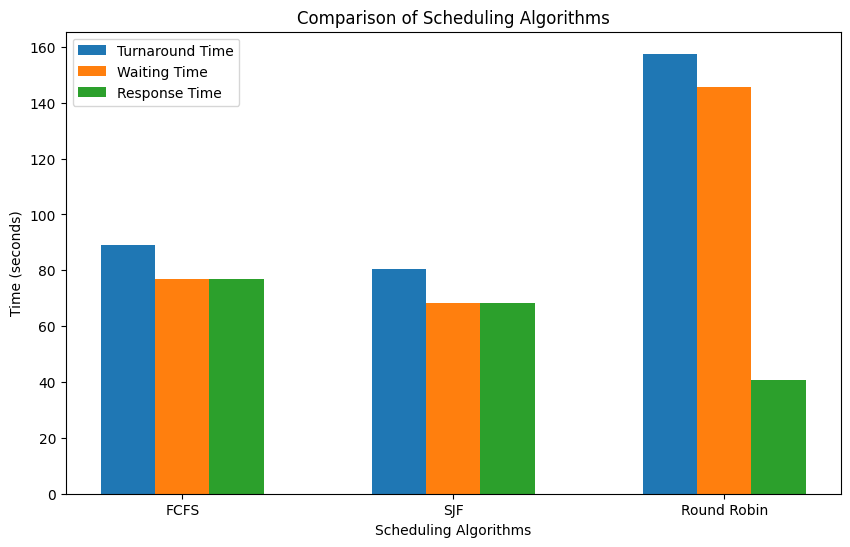

In [46]:
if __name__ == "__main__":
    print("\nStarting FCFS Simulation...")
    fcfs_stats = main(teller_service_fcfs, "FCFS")
    print("\nStarting SJF Simulation...")
    sjf_stats = main(teller_service_sjf, "SJF")
    # print("\nStarting Preemptive SJF Simulation...")
    # preemptive_sjf_stats = main(teller_service_preemptive_sjf, "Preemptive SJF")
    print("\nStarting Round Robin Simulation...")
    rr_stats = main(teller_service_rr, "Round Robin")
    plot_results(fcfs_stats, sjf_stats, rr_stats)

In [47]:
customers = list(range(1,101))


def plot_individual_algorithm(customers, turnaround_times, waiting_times, response_times, title):
        plt.figure(figsize=(12, 8))


        plt.plot(customers, turnaround_times, color='b', label='Turnaround Time')



        plt.plot(customers, waiting_times, color='g', label='Waiting Time')
        plt.xlabel('Customer')
        plt.ylabel('Time (seconds)')



        plt.plot(customers, response_times, color='r', label='Response Time')

        plt.legend()

        plt.show()

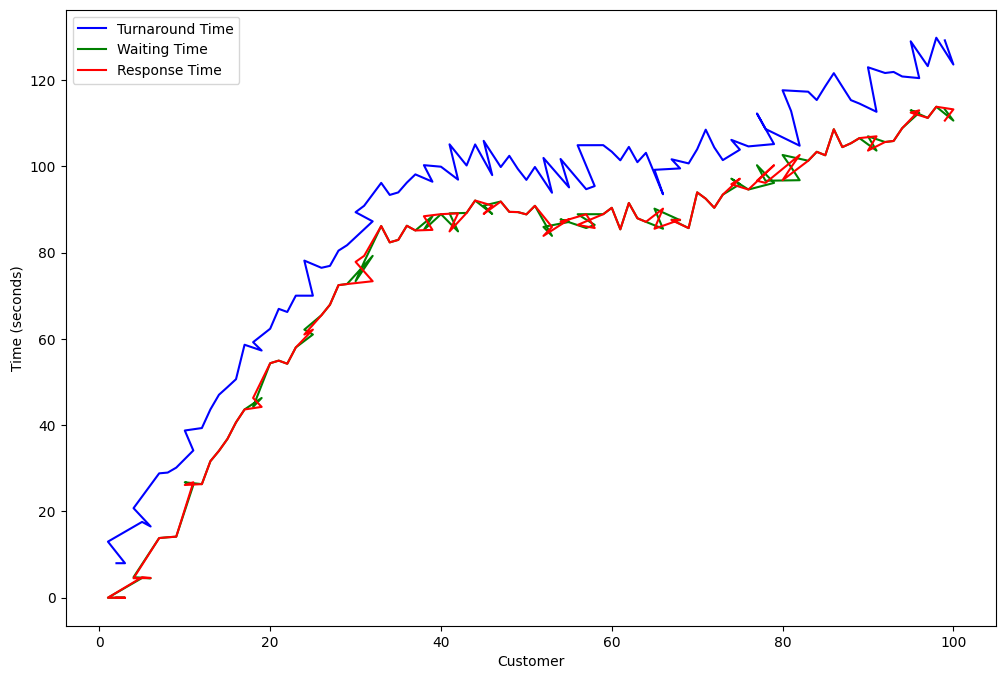

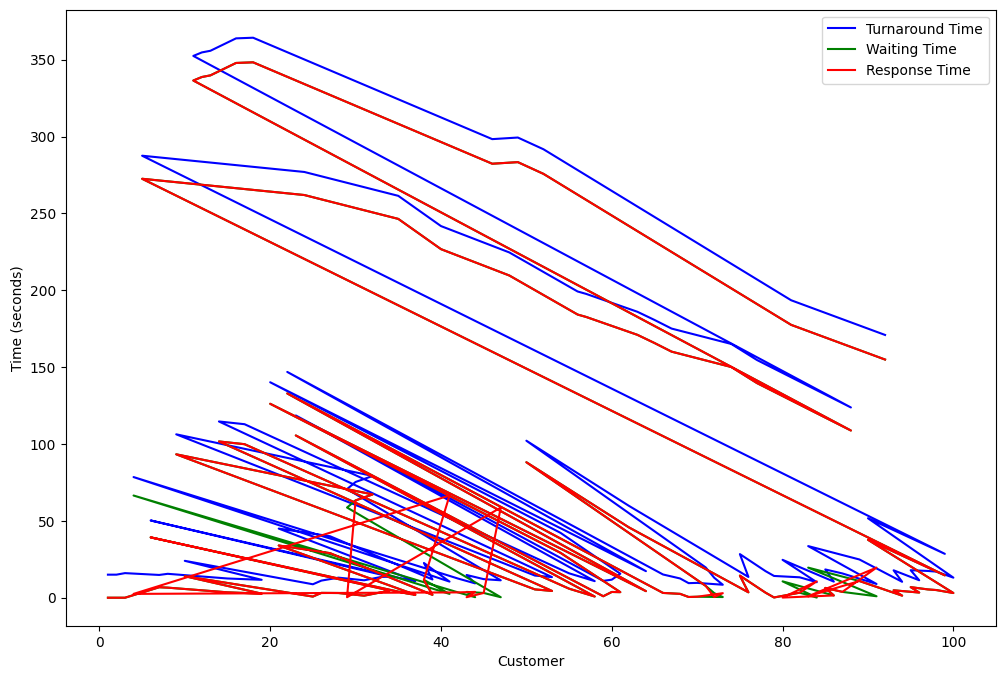

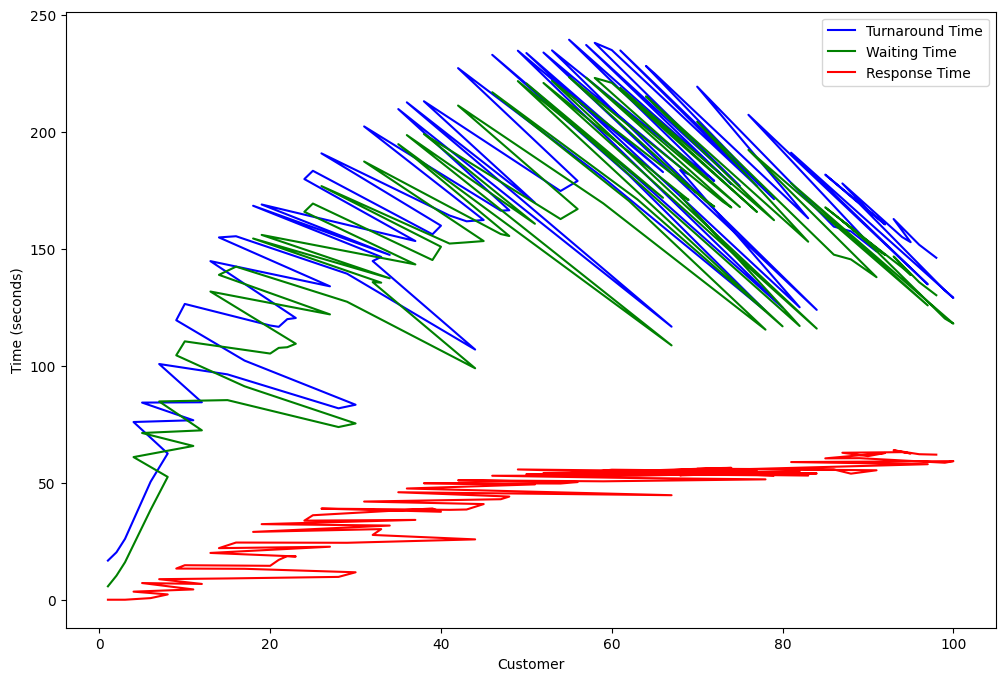

In [48]:
plot_individual_algorithm(fcfs_customers, fcfs_turnaround_times, fcfs_waiting_times, fcfs_response_times, 'FCFS')
plot_individual_algorithm(sjf_customers, sjf_turnaround_times, sjf_waiting_times, sjf_response_times, 'SJF')
plot_individual_algorithm(rr_customers, rr_turnaround_times, rr_waiting_times, rr_response_times, 'Round Robin')